Transfer of the graphics scripts to Notebook in an effort to speed up devlopment...


In [1]:
## Imports, Constants, and MatPlot Magic

import datetime
import itertools
import math
import copy
import time
import random
import sys

import glob

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

%matplotlib inline
#
# To Save Figs:
# plt.savefig('xxx.{pdf/png}',bbox_inches='tight')
#

__FNAME_STRING = "/merged_raw_samples*.data"
__INPUT_DIRECTORY = "../../Euclidean-TSP-Results/merged/"
__OUTPUT_DIRECTORY = "./"

## Graph Settings
matplotlib.style.use('bmh')
font = {'size'   : 18}
matplotlib.rc('font', **font)

In [2]:
### Data Instance Class Definition.

class Metrics:
    SHAPLEY = "Shapley"
    CHRIS = "Christofides"
    ROUTEMARGIN = "Shortcut Distance"
    MOAT = "Moat Packing"
    REROUTE = "Re-routed Margin"
    DIST = "Depot Distance"
    MIX = "Blend"
    TUP = (SHAPLEY, CHRIS, ROUTEMARGIN, MOAT, REROUTE, DIST, MIX)
    GRAPH = (ROUTEMARGIN, REROUTE, DIST, MOAT, CHRIS, MIX)
    STAT = (ROUTEMARGIN, REROUTE, DIST, MOAT, CHRIS, MIX)
    NO_CRAP = (DIST, CHRIS, MIX)

class route_test:
    def __init__(self):
        self.number_of_location = 0
        # Values is a dict from Location# --> Dictionary of Metrics with values...
        self.values = {}
        self.normalized = {}

    def print_values(self):
        print("Number of Locations: " + str(self.number_of_locations))
        outstr = ""
        for i in self.values.keys():
            for k in self.values[i]:
                print("Location " + str(i) + " : " + k + " = " + str(self.values[i][k]))

    def print_normalized(self):
        print("Number of Locations: " + str(self.number_of_locations))
        for i in self.normalized.keys():
            for k in self.normalized[i]:
                print("Location " + str(i) + " : " + k + " = " + str(self.normalized[i][k]))

    def compute_normalized(self):
        # For each type, sum every rec of that type, then divide each by the total.
        if self.values == {}:
            print("Big Error... Values aren't computed")
            exit()

        blank = {c:-1.00 for c in Metrics.TUP}
        self.normalized = {i:copy.copy(blank) for i in range(1, self.number_of_locations)}

        for c_metric in Metrics.TUP:
            running_sum = 0
            for c_index in self.values.keys():
                running_sum += self.values[c_index][c_metric]
            if running_sum == 0:
                print("GOT NO VALUES!")
                print(self.values)

            for k in self.values.keys():
                self.normalized[k][c_metric] = self.values[k][c_metric] / running_sum			




In [3]:
### Parsing Function for Datafiles.

#parse off the data...
def parseDataFile(inf):
    ''' Parse info for the RAW Files... 
    Recs are:
    4 0 0 0 0 0 0
    4 612.674 449.554 184.446 196.4 1621.71 98.8617
    4 670.715 480.612 1273.9 280.7 1979.6 178.947
    4 696.214 1109.33 119.401 1502.5 1979.6 819.503

    The fields are:
    (1) The number of customers (including depot)
    (2) ApproShapley Approx (1K iters) with Concorde for TSP solution
    (3) ApproShapley Approx (1K iters) with Christofedias Tree approx for TSP solution
    (4) Routing Margin Allocation (keeping the TSP solution for the grand tour, delete a customer and charge them the delta in the tour cost while keeping all the routes the same (simply skipping agent i in the tour).)
    (5) Moat Packing allocation
    (6) Reroute Marginal Allocation (delete customer i and then re-compute the optimal route.  Charging the deleted customer the delta in cost from the optimal route with i to the optimal route without i.)
    (7) Depot distance

    '''

    #Print the first line of whatever we got...
    fin = inf.readlines()
    allrecs = []

    while len(fin) > 0:
        #Parse number of rec's
        current_example = route_test()
        current_example.number_of_locations = int(fin[0].split(" ")[0].strip())
        fin.pop(0)

        smallest_negitive_reroute = (-1000.0, 1)
        smallest_negitive_routemargin = (-1000.0, 1)
        for i in range(current_example.number_of_locations - 1):
            #Break Up an Entry...
            clocation = fin.pop(0)
            bits = clocation.strip().split(" ")
            bits = bits[1:len(bits)]
            values = {}
            for c in range(len(bits)):
                values[Metrics.TUP[c]] = float(bits[c])

            # 60/40 Blend...
            values[Metrics.MIX] = 0.318*values[Metrics.MOAT] + 0.579*values[Metrics.DIST] + 0.009
            #Change over for new model?
            # 25/75 Blend...
            #[[ 0.31781509  0.57690471]]
            #[ 0.00920163
            #values[Metrics.MIX2] = 

            ## Check and 0 for negitive Shortcut and Re-route...
            if values[Metrics.REROUTE] < 0.0:
                #Capture the least negitive guy.. (Fix Kendall Tau error for unranked list)
                if values[Metrics.REROUTE] > smallest_negitive_reroute[0]:
                    smallest_negitive_reroute = (values[Metrics.REROUTE], i+1)
                values[Metrics.REROUTE] = 0.0
            if values[Metrics.ROUTEMARGIN] < 0.0:
                if values[Metrics.ROUTEMARGIN] > smallest_negitive_routemargin[0]:
                    smallest_negitive_routemargin = (values[Metrics.ROUTEMARGIN], i+1)
                values[Metrics.ROUTEMARGIN] = 0.0
            current_example.values[i+1] = values
        #current_example.print_values()

        # Check for potential all 0's for REROUTE or SHORTCUT...
        if all(current_example.values[i][Metrics.REROUTE] == 0.0000 for i in current_example.values.keys()):
            for i in current_example.values.keys():
                current_example.values[i][Metrics.REROUTE] = 1.0
            current_example.values[smallest_negitive_reroute[1]][Metrics.REROUTE] = 1.1

        if all(current_example.values[i][Metrics.ROUTEMARGIN] == 0.0000 for i in current_example.values.keys()):
            for i in current_example.values.keys():
                current_example.values[i][Metrics.ROUTEMARGIN] = 1.0
            print(str(smallest_negitive_routemargin))
            current_example.print_values()
            current_example.values[smallest_negitive_routemargin[1]][Metrics.ROUTEMARGIN] = 1.1
            print(str(smallest_negitive_routemargin))
            exit()


        allrecs.append(current_example)

    return allrecs

In [4]:
### Import and Parse DataFiles.
print("Importing Data files...")

# Glob off all files in the input directory
files = glob.glob(__INPUT_DIRECTORY + __FNAME_STRING)
all_rmse = {c:{} for c in Metrics.STAT}
all_max_pointwise = {c:{} for c in Metrics.STAT}
all_min_pointwise = {c:{} for c in Metrics.STAT}
KT_Tests = {c:{} for c in Metrics.STAT}
error_scatter_x = {c:{} for c in Metrics.STAT}
error_scatter_y = {c:{} for c in Metrics.STAT}

kt_top = {c:{} for c in Metrics.STAT}
kt_top_3 = {c:{} for c in Metrics.STAT}
kt_bottom = {c:{} for c in Metrics.STAT}
kt_nsig_p = {c:{} for c in Metrics.STAT}
kt_median_p = {c:{} for c in Metrics.STAT}
kt_worst_p = {c:{} for c in Metrics.STAT}


x_labels = []

YMAX = 0.0

n_trials = []

print(files)

# Peal off each of the files and try to parse it...
for cfile in sorted(files):
    print("Parsing: " + cfile)
    inf = open(cfile, 'r')
    recs = parseDataFile(inf)
    inf.close()

    #Normalize the records.
    [i.compute_normalized() for i in recs]
    n_trials.append(len(recs))

    # Print the Normalized Rec's...
    #[i.print_normalized() for i in recs]
    #exit()

    #Keep track of our x_labels...
    # Remove the Depot from n locs 
    x_labels.append(recs[0].number_of_locations - 1)
    x_labels = sorted(x_labels)

    #ease of use.
    n_locations = recs[0].number_of_locations

    #Create empty space in the KT_Test Map
    for c_metric in KT_Tests.keys():
        KT_Tests[c_metric][n_locations] = {}

    for c_metric in Metrics.STAT:
        all_rmse[c_metric][n_locations] = []
        all_max_pointwise[c_metric][n_locations] = []
        all_min_pointwise[c_metric][n_locations] = []

        error_scatter_x[c_metric][n_locations] = []
        error_scatter_y[c_metric][n_locations] = []

        kt_top[c_metric][n_locations] = 0
        kt_top_3[c_metric][n_locations] = 0
        kt_bottom[c_metric][n_locations] = 0
        m_p = []

        c_trial = 0
        for c_rec in recs:
            RMSE = 0
            sv = []
            metricrank = []
            t_error = []
            for c_location in sorted(c_rec.normalized.keys()):
                # RSME Calc
                point_error = c_rec.normalized[c_location][c_metric] - c_rec.normalized[c_location][Metrics.SHAPLEY]
                RMSE += point_error * point_error

                #KT stat Calc
                sv.append(c_rec.values[c_location][Metrics.SHAPLEY])
                metricrank.append(c_rec.values[c_location][c_metric])

                #Error Size Calc
                error_scatter_x[c_metric][n_locations].append(round(c_rec.normalized[c_location][Metrics.SHAPLEY] * 100.0, 4))
                #error_scatter_y[c_metric][recs[0].number_of_locations].append(round(abs(c_rec.normalized[c_location][c_metric] - c_rec.normalized[c_location][Metrics.SHAPLEY]) / c_rec.normalized[c_location][Metrics.SHAPLEY], 4))

                t_error.append(abs(c_rec.normalized[c_location][c_metric] - \
                                         c_rec.normalized[c_location][Metrics.SHAPLEY]))

                error_scatter_y[c_metric][n_locations].append( \
                    round(abs(c_rec.normalized[c_location][c_metric] - \
                    c_rec.normalized[c_location][Metrics.SHAPLEY]) * 100, 4))
    
            all_max_pointwise[c_metric][n_locations].append(max(t_error))
            all_min_pointwise[c_metric][n_locations].append(min(t_error))
            all_rmse[c_metric][n_locations].append(math.sqrt(RMSE))
            if math.sqrt(RMSE) > YMAX:
                YMAX = math.sqrt(RMSE)

            #KT test stat testing...
            KT_Tests[c_metric][n_locations][c_trial] = stats.mstats.kendalltau(sv, metricrank,use_ties=True)
            #KT_Tests[c_metric][recs[0].number_of_locations][c_trial] = stats.kendalltau(sv, metricrank)
            #KT_Tests[c_metric][recs[0].number_of_locations][c_trial] = -1, -1

            m_p.append(KT_Tests[c_metric][n_locations][c_trial][1])
            c_trial += 1
            if sv.index(max(sv)) == metricrank.index(max(metricrank)):
                kt_top[c_metric][n_locations] += 1
            if sv.index(min(sv)) == metricrank.index(min(metricrank)):
                kt_bottom[c_metric][n_locations] += 1
            
            ### Here, need to take the top 3 and check..
            top_sv = list(enumerate(sv))
            top_sv = sorted(top_sv, key=lambda x:x[1], reverse=True)
            topn_sv = set([l for l,v in top_sv[:3]])

            top_kt = list(enumerate(metricrank))
            top_kt = sorted(top_kt, key=lambda x:x[1], reverse=True)
            topi_kt = [l for l,v in top_kt[:1]]
            
            if topi_kt[0] in topn_sv:
                kt_top_3[c_metric][n_locations] += 1
            

        kt_nsig_p[c_metric][n_locations] = sum(x < 0.05 for x in m_p)
        kt_median_p[c_metric][n_locations] = np.median(m_p)
        kt_worst_p[c_metric][n_locations] = max(m_p)

print("Done")

Importing Data files...
['../../Euclidean-TSP-Results/merged/merged_raw_samples-s10.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s11.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s12.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s13.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s14.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s15.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s16.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s17.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s18.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s19.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s20.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s21.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s5.data', '../../Euclidean-TSP-Results/merged/merged_raw_samples-s6.data', '../../Euclidean-TSP-Results/merged/merged_raw_sample

In [5]:
#print out some KT stats...
print("\n")
print("\nMedian KT p Values by Metric and Size")
outline = "{},".format('Metric')
for i in sorted(kt_median_p[Metrics.CHRIS].keys()):
    outline += "{},".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{},".format(c_metric)
    for i in sorted(kt_median_p[c_metric].keys()):
        outline += "{},".format(str(round(kt_median_p[c_metric][i], 4)))
    print(outline)

print("\nMax KT p Values by Metric and Size")
outline = "{},".format('Metric')
for i in sorted(kt_worst_p[Metrics.CHRIS].keys()):
    outline += "{},".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{},".format(c_metric)
    for i in sorted(kt_worst_p[c_metric].keys()):
        outline += "{},".format(str(round(kt_worst_p[c_metric][i], 4)))
    print(outline)

print("\nN KT p Values p < 0.05 by Metric and Size")
outline = "{},".format('Metric')
for i in sorted(kt_worst_p[Metrics.CHRIS].keys()):
    outline += "{},".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{},".format(c_metric)
    for i in sorted(kt_worst_p[c_metric].keys()):
        outline += "{},".format(str(kt_nsig_p[c_metric][i]))
    print(outline)

#Pull out possibly different number of trials per game size.
print("\nNumber out of " + str(n_trials) + " with matching top ranked (costliest) elemnent.")
outline = "{},".format('Metric')
for i in sorted(kt_top[Metrics.CHRIS].keys()):
    outline += "{},".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{},".format(c_metric)
    for i in sorted(kt_top[c_metric].keys()):
        outline += "{},".format(str(kt_top[c_metric][i]))
    print(outline)
    
    
##### Paper Tables.
print(kt_nsig_p[Metrics.CHRIS])

print("\n% KT p Values p < 0.05 by Metric and Size")
outline = "{}&".format('Metric')
for i in [10,20,'all']:
    outline += "{:^10}&".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{:^10}&".format(c_metric)
    for i in [10,15,20]:
        outline += "{:^10}&".format(str(round((kt_nsig_p[c_metric][x_labels.index(i)] / 1070.0) * 100.0 , 4)))
# #All the data...
    outline += "{:^10}&".format(str(round((sum(kt_nsig_p[c_metric].values()) / float(sum(n_trials)))*100.0, 4)))
    print(outline)

print("\nNumber out of " + str(n_trials) + " with matching top ranked (costliest) elemnent.")
outline = "{:^10},".format('Metric')
for i in [10,15,20,'all']:
    outline += "{:^10}&".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{},".format(c_metric)
    for i in [10,15,20]:
        outline += "{:^10}&".format(str(round((kt_top[c_metric][x_labels.index(i)] / 1070.0) * 100.0 , 4)))
    outline += "{:^10}&".format(str(round((sum(kt_top[c_metric].values()) / float(sum(n_trials)))*100.0, 4)))
    print(outline)

    
print("\nNumber out of " + str(n_trials) + " with matching set of top 3 elements.")
outline = "{:^10},".format('Metric')
for i in [10,15,20,'all']:
    outline += "{:^10}&".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{},".format(c_metric)
    for i in [10,15,20]:
        outline += "{:^10}&".format(str(round((kt_top_3[c_metric][x_labels.index(i)] / 1070.0) * 100.0 , 4)))
    outline += "{:^10}&".format(str(round((sum(kt_top_3[c_metric].values()) / float(sum(n_trials)))*100.0, 4)))
    print(outline)    

    
print("mean max and SD absolute pointwise error.")
outline = "{}&".format('Metric')
for i in [10,15,20,'all']:
    outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
print(outline)
for c_metric in Metrics.STAT:
    outline = "{:^10}&".format(c_metric)
    for i in [10,15,20]:
        outline += "{:^10}&".format(str(round(np.mean(all_max_pointwise[c_metric][i]), 4))) + \
                   "{:^10}&".format(str(round(np.std(all_max_pointwise[c_metric][i]), 4)))
#        outline += "{:^10}&".format(str(round(all_min_pointwise[c_metric][i], 4)))
    # All Data
    outline += "{}&".format(str(round(np.mean(np.hstack( all_max_pointwise[c_metric].values() )), 4))) + \
               "{}&".format(str(round(np.std(np.hstack(all_max_pointwise[c_metric].values())), 4)))
    print(outline)
    

# print(kt_nsig_p[Metrics.CHRIS].values())
# print(sum(kt_nsig_p[Metrics.CHRIS].values()) / float(sum(n_trials)))
# print(n_trials)
#     print("Average and SD KT Correlation Values by Metric and Size")
#     outline = "{}&".format('Metric')
#     for i in [10,15,20, 'all']:
#         outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
#     print(outline)
#     for c_metric in Metrics.STAT:
#         outline = "{}&".format(c_metric)
#         for i in [10,15,20]:
#             outline += "{}&".format(str(round(Avg[c_metric][x_labels.index(i)], 4))) + \
#                 "{}&".format(str(round(StDev[c_metric][x_labels.index(i)], 4)))
#         #All the data...
#         outline += "{}&".format(str(round(np.mean(Avg[c_metric]), 4))) + \
#                 "{}&".format(str(round(np.std(Avg[c_metric]), 4)))
#         print(outline)




Median KT p Values by Metric and Size
Metric,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,
Shortcut Distance,0.4969,0.6242,0.573,0.4527,0.4579,0.5316,0.5312,0.4835,0.4929,0.5418,0.4767,0.52,0.4713,0.5098,0.4717,0.5062,0.5164,
Re-routed Margin,0.1742,0.1416,0.0909,0.0509,0.0478,0.0606,0.0603,0.0516,0.0397,0.0381,0.0328,0.026,0.0244,0.0211,0.017,0.0158,0.0137,
Depot Distance,0.1742,0.1416,0.0909,0.0509,0.026,0.0218,0.0157,0.0102,0.0061,0.0073,0.0052,0.0035,0.003,0.0023,0.0022,0.0015,0.0015,
Moat Packing,0.1742,0.1416,0.0909,0.0985,0.0833,0.0953,0.0892,0.0734,0.0746,0.0672,0.0554,0.0536,0.0586,0.048,0.0308,0.0359,0.0379,
Christofides,0.1742,0.05,0.0146,0.0107,0.0065,0.0035,0.0032,0.0014,0.001,0.0006,0.0004,0.0003,0.0002,0.0001,0.0001,0.0001,0.0,
Blend,0.1742,0.05,0.0388,0.0243,0.0133,0.0067,0.0056,0.004,0.0016,0.0015,0.0012,0.0009,0.0009,0.0005,0.0004,0.0003,0.0003,

Max KT p Values by Metric and Size
Metric,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,
Shortcut Distance,1.0,1.0,0.85

Generating RMSE Snakes
Creating RMSE Graphs
Average and SD RMSE by Metric and Size
Metric&    10    &    SD    &    15    &    SD    &    20    &    SD    &   all    &    SD    &
Shortcut Distance&0.385&0.0968&0.3342&0.0764&0.2992&0.0606&0.3727&0.0564&
Re-routed Margin&0.2565&0.0699&0.2168&0.0533&0.1915&0.0424&0.2493&0.0488&
Depot Distance&0.0994&0.0275&0.095&0.0235&0.0893&0.0195&0.0978&0.0059&
Moat Packing&0.1617&0.0502&0.1437&0.037&0.1302&0.0293&0.1564&0.0197&
Christofides&0.0495&0.0216&0.0526&0.0177&0.0523&0.0142&0.052&0.0046&
Blend&0.071&0.0191&0.0742&0.0168&0.0733&0.0154&0.0745&0.0075&


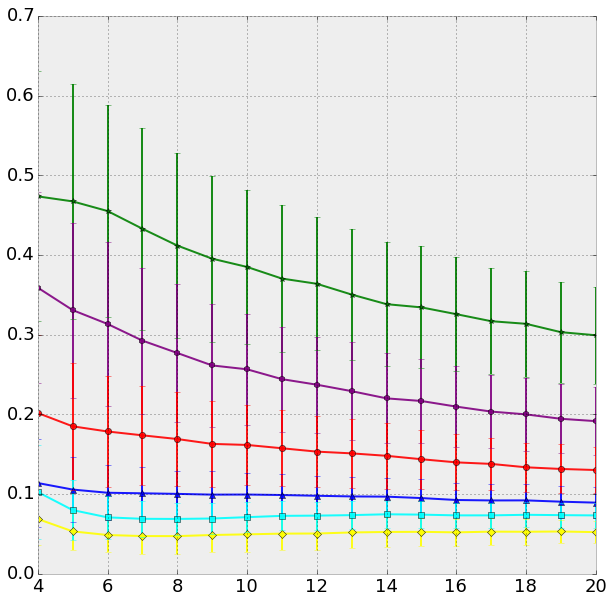

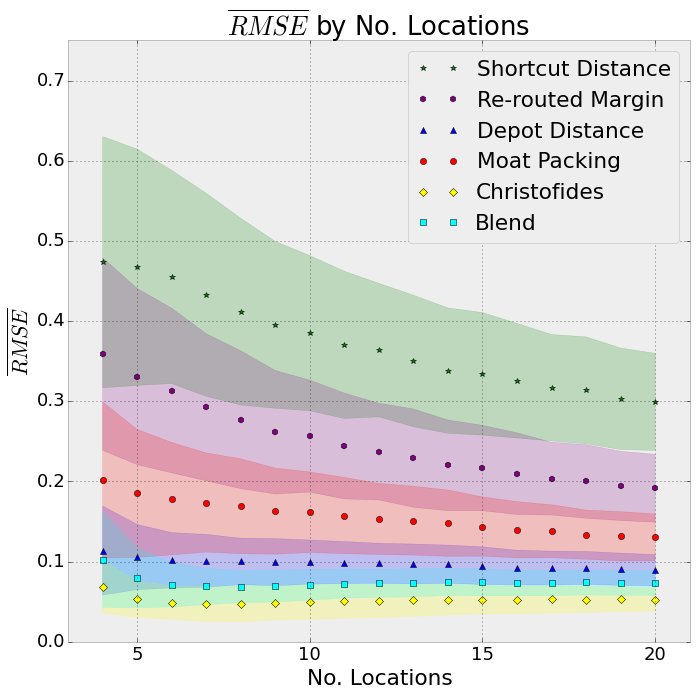

In [8]:
# RMSE PLOTS AND STATISTICS.
def make_error_boxplot(Big_Plot, x_labels, y_max):
    for c_metric in Metrics.STAT:
        #Create Figure Object
        fig = plt.figure(figsize=(10, 10))
        # Create an Axes object.
        ax1 = fig.add_subplot(1,1,1) # one row, two column, first plot

        #make pointers for labels and boxes...
        box_plots = []
        for i in sorted(Big_Plot[c_metric].keys()):
            box_plots.append(Big_Plot[c_metric][i])

        ax1.boxplot(box_plots)
        xtickNames = plt.setp(ax1, xticklabels=x_labels)
        #plt.setp(xtickNames)
        ax1.set_title("RMSE Box Plot -- " + str(c_metric))
        ax1.set_ylabel("Root Mean Squared Error")
        ax1.set_xlabel("Number of Locations")
        ax1.set_ylim(0, y_max)
        #draw it to the pdf.
        #plt.draw()
        #plt.tight_layout()
        #plt.savefig(pp, format='pdf')

# RMSE ERROR SNAKES...
def make_error_snakes(Big_Plot, x_labels, y_max):
    Mins = {c:[] for c in Metrics.STAT}
    Maxes = {c:[] for c in Metrics.STAT}
    Avg = {c:[] for c in Metrics.STAT}
    StDev = {c:[] for c in Metrics.STAT}
    Median = {c:[] for c in Metrics.STAT}
    ErMax = 0.7

    for c_metric in Metrics.STAT:
        for c_loc in sorted(Big_Plot[c_metric]):
            Mins[c_metric].append(min(Big_Plot[c_metric][c_loc]))
            Maxes[c_metric].append(max(Big_Plot[c_metric][c_loc]))
            Avg[c_metric].append(sum(Big_Plot[c_metric][c_loc]) / len(Big_Plot[c_metric][c_loc]))
            StDev[c_metric].append(np.std(Big_Plot[c_metric][c_loc]))
            Median[c_metric].append(np.median(Big_Plot[c_metric][c_loc]))
            
    print("Creating RMSE Graphs")

    #
    ### THIS SECTION MAKES THE LINE GRAPH WITH ERROR BARS!!
    #

    # Create a Figure object.
    fig = plt.figure(figsize=(10, 10))
    # Create an Axes object.
    ax = fig.add_subplot(1,1,1) # one row, one column, first plot
    colors = [ "green", "purple","blue","red", "yellow",  "cyan", "magenta"]
    markers = ["*", "h", "^", "o", "D", "s", "h"]

    for c_element, c_metric in enumerate(Metrics.GRAPH):
        ax.errorbar(x_labels, Avg[c_metric], yerr=StDev[c_metric], \
            color=colors[c_element], marker=markers[c_element], label=c_metric, alpha=0.9)

#     # Add a title.
#     ax.set_title("Average RMSE by N. Locations")
#     # Add some axis labels.
#     ax.set_xlabel("Number of Locations")
#     ax.set_ylabel("Average RMSE")
#     #ax2.set_xlim(x_labels[0]-1, x_labels[len(x_labels)-1]+1)
#     ax.set_ylim(0, y_max)
#     ax.legend()
#     plt.draw()
#     plt.tight_layout()

    #
    ### THIS SECTION MAKES SOME SNAKES!!
    #

    #Attempt to plot the Average Error for them all...
    # Create a Figure object.
    fig = plt.figure(figsize=(10, 10))
    # Create an Axes object.
    ax = fig.add_subplot(1,1,1) # one row, one column, first plot

    for c_element, c_metric in enumerate(Metrics.GRAPH):
        thigh = []
        tlow = []
        for i in range(len(Avg[c_metric])):
            thigh.append(Avg[c_metric][i]+StDev[c_metric][i])
            tlow.append(Avg[c_metric][i]-StDev[c_metric][i])

        ax.plot(x_labels, Avg[c_metric], color=colors[c_element], \
            marker=markers[c_element], label=c_metric, mec="black", linestyle="None")
        ax.fill_between(x_labels, tlow, thigh, color=colors[c_element], alpha=0.2)

    # Add a title.
    ax.set_title("$\overline{RMSE}$ by No. Locations")
    # Add some axis labels.
    ax.set_xlabel("No. Locations")
    ax.set_ylabel("$\overline{RMSE}$")
    ax.set_xlim(x_labels[0]-1, x_labels[len(x_labels)-1]+1)
    ax.set_ylim(0, 0.75)
    plt.yticks(np.arange(0.0, 0.75, 0.1))
    ax.legend()
    plt.draw()
    plt.tight_layout()
    plt.savefig('synthetic_rmse.png',bbox_inches='tight')
    #plt.savefig(pp, format='pdf')
    
    # #
    # ### Snake fills with Median and Max (so top 50%)
    # #
    # Create a Figure object.
#     fig = plt.figure(figsize=(10, 10))
#     # Create an Axes object.
#     ax = fig.add_subplot(1,1,1) # one row, one column, first plot
#     colors = ["blue","red", "yellow",  "cyan", "magenta"]
#     markers = ["^", "o", "D", "s", "h"]

#     c_element = 0
#     for c_element, c_metric in enumerate(Metrics.NO_CRAP):
#         thigh = []
#         tlow = []
#         for i in range(len(Maxes[c_metric])):
#             #Clamp value for rounding error..
#             thigh.append(1.0) if Maxes[c_metric][i] > 1.0 else thigh.append(Maxes[c_metric][i])
#             tlow.append(Median[c_metric][i])

#         print(thigh)
#         #ax.plot(x_labels, Mins[c_metric], color=colors[c_element], \
#         #    marker=markers[c_element], label=c_metric, mec="black", linestyle="None")
#         ax.plot(x_labels, Median[c_metric], color=colors[c_element], \
#             marker=markers[c_element], label=c_metric, mec="black", linestyle="None")
#         ax.fill_between(x_labels, tlow, thigh, color=colors[c_element], alpha=0.2)

#     # Add a title.
#     ax.set_title("Range between Median and Max Error")
#     # Add some axis labels.
#     ax.set_xlabel("Number of Locations")
#     ax.set_ylabel("Min and Max Root Mean Squared Error")
#     ax.set_xlim(x_labels[0]-1, x_labels[len(x_labels)-1]+1)
#     ax.set_ylim(0, 0.9)
#     ax.legend()
#     plt.draw()
#     plt.tight_layout()
# #    plt.savefig(pp, format='pdf')
    

    ## Dump the stuff to the screen for tables:
    ## Note: this is messed up, we have a list and the indicies don't correspond to anything....
    print("Average and SD RMSE by Metric and Size")
    outline = "{}&".format('Metric')
    for i in [10,15,20, 'all']:
        outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
    print(outline)
    for c_metric in Metrics.STAT:
        outline = "{}&".format(c_metric)
        for i in [10,15,20]:
            outline += "{}&".format(str(round(Avg[c_metric][x_labels.index(i)], 4))) + \
                "{}&".format(str(round(StDev[c_metric][x_labels.index(i)], 4)))
        #All the data...
        outline += "{}&".format(str(round(np.mean(Avg[c_metric]), 4))) + \
                "{}&".format(str(round(np.std(Avg[c_metric]), 4)))
        print(outline)

### Make a graph of the errors...
#Try to make a box plot with the labels 'n' such...
#pp = PdfPages(sys.argv[2] + "AggError.pdf")

#print("Generating RMSE Error Boxes")
#make_error_boxplot(all_rmse, x_labels, YMAX)

#Let's graph the Average, Max, and Min points all together...
print("Generating RMSE Snakes")
make_error_snakes(all_rmse, x_labels, 1.0)

# for n,i in enumerate(all_rmse[Metrics.ROUTEMARGIN][5]):
#     if i > 1.0:
#         print(n,i)

Generating Pointwise Max/Min Plots


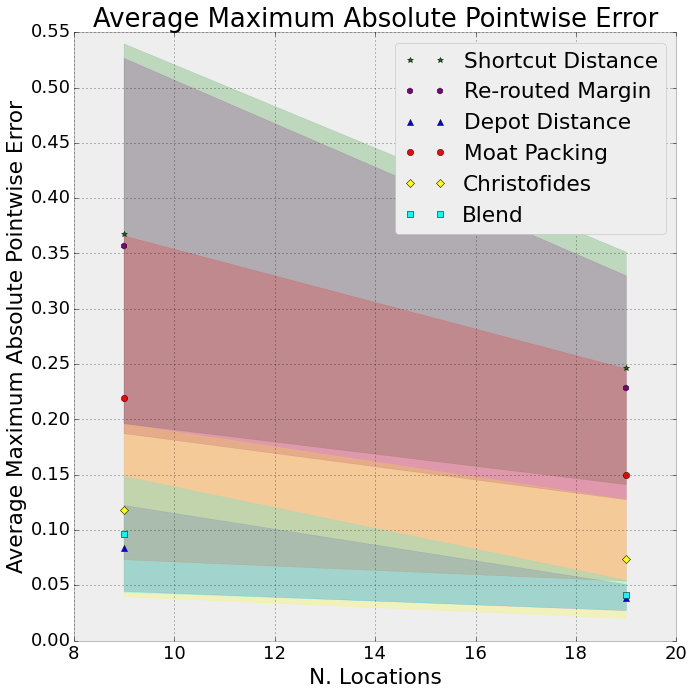

In [7]:
#### Pointwise Error Plots.

def make_pointwise_error_snakes(err, x_labels, y_max):
    Mins = {c:[] for c in Metrics.STAT}
    Maxes = {c:[] for c in Metrics.STAT}
    Avg = {c:[] for c in Metrics.STAT}
    StDev = {c:[] for c in Metrics.STAT}

    for c_metric in Metrics.STAT:
        for c_loc in sorted(err[c_metric]):
            Mins[c_metric].append(min(err[c_metric][c_loc]))
            Maxes[c_metric].append(max(err[c_metric][c_loc]))
            Avg[c_metric].append(sum(err[c_metric][c_loc]) / len(err[c_metric][c_loc]))
            StDev[c_metric].append(np.std(err[c_metric][c_loc]))
            
    colors = [ "green", "purple","blue","red", "yellow",  "cyan", "magenta"]
    markers = ["*", "h", "^", "o", "D", "s", "h"]
    # Create a Figure object.
    fig = plt.figure(figsize=(10, 10))
    # Create an Axes object.
    ax = fig.add_subplot(1,1,1) # one row, one column, first plot

    for c_element, c_metric in enumerate(Metrics.GRAPH):
        thigh = []
        tlow = []
        for i in range(len(Avg[c_metric])):
            thigh.append(Avg[c_metric][i]+StDev[c_metric][i])
            tlow.append(Avg[c_metric][i]-StDev[c_metric][i])

        ax.plot(x_labels, Avg[c_metric], color=colors[c_element], \
            marker=markers[c_element], label=c_metric, mec="black", linestyle="None")
        ax.fill_between(x_labels, tlow, thigh, color=colors[c_element], alpha=0.2)

    # Add a title.
    ax.set_title("Average Maximum Absolute Pointwise Error")
    # Add some axis labels.
    ax.set_xlabel("N. Locations")
    ax.set_ylabel("Average Maximum Absolute Pointwise Error")
    ax.set_xlim(x_labels[0]-1, x_labels[len(x_labels)-1]+1)
    ax.set_ylim(0, y_max)
    plt.yticks(np.arange(0.0, 0.6, 0.05))
    ax.legend()
    plt.draw()
    plt.tight_layout()
    plt.savefig('synthetic_max.png',bbox_inches='tight')

# Graph out the minimum and maximum pointwise errors for the locations.
print("Generating Pointwise Max/Min Plots")
make_pointwise_error_snakes(all_max_pointwise, x_labels, 0.52)


KT Graphs
Average and SD KT Correlation Values by Metric and Size
Metric&    10    &    SD    &    15    &    SD    &    20    &    SD    &   all    &    SD    &
Shortcut Distance&0.0098&0.2403&0.0031&0.1931&-0.0076&0.1604&-0.0027&0.0106&
Re-routed Margin&0.4732&0.1947&0.416&0.1505&0.3908&0.1397&0.4828&0.0892&
Depot Distance&0.5815&0.1791&0.54&0.1524&0.5018&0.1454&0.5659&0.0385&
Moat Packing&0.4098&0.2235&0.3526&0.1787&0.3392&0.161&0.419&0.0829&
Christofides&0.7186&0.1663&0.6791&0.143&0.6463&0.1286&0.7048&0.0374&
Blend&0.6834&0.1567&0.6206&0.1385&0.5706&0.1369&0.6616&0.0593&
Average and SD KT Correlation Values by Metric and Size
Metric&    10    &    SD    &    15    &    SD    &    20    &    SD    &   all    &    SD    &
Shortcut Distance&0.0098&0.2403&0.0031&0.1931&-0.0076&0.1604&-0.0027&0.0106&
Re-routed Margin&0.4732&0.1947&0.416&0.1505&0.3908&0.1397&0.4828&0.0892&
Depot Distance&0.5815&0.1791&0.54&0.1524&0.5018&0.1454&0.5659&0.0385&
Moat Packing&0.4098&0.2235&0.3526&0.1787&0.339

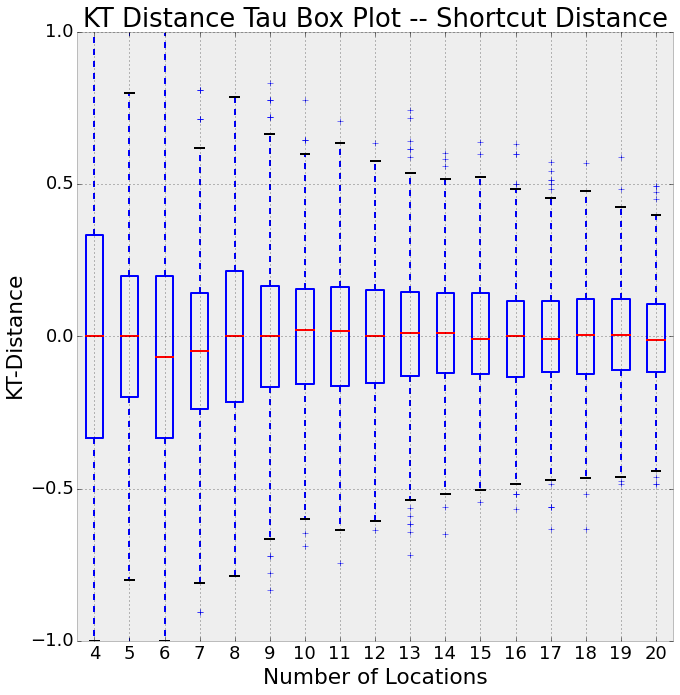

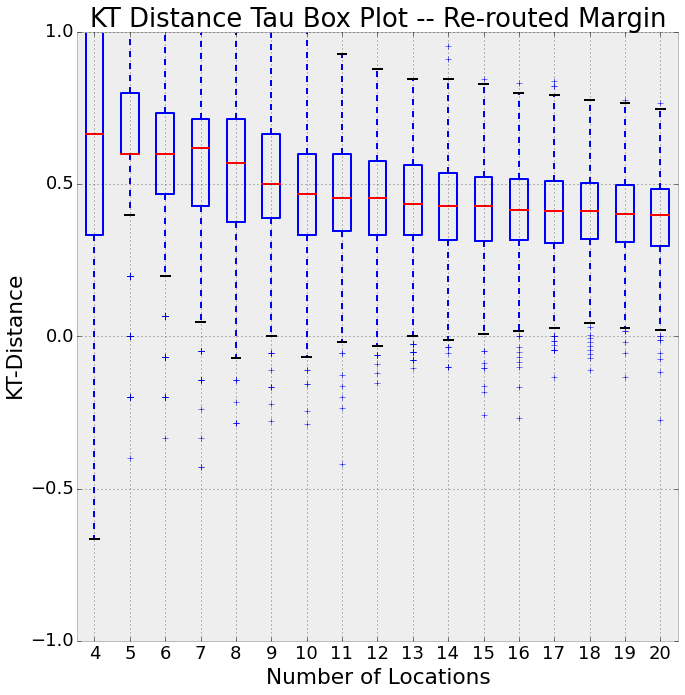

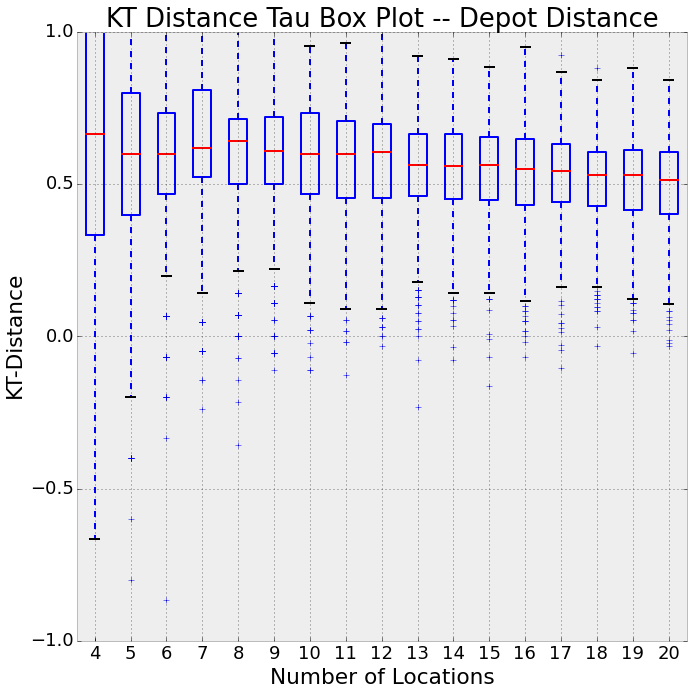

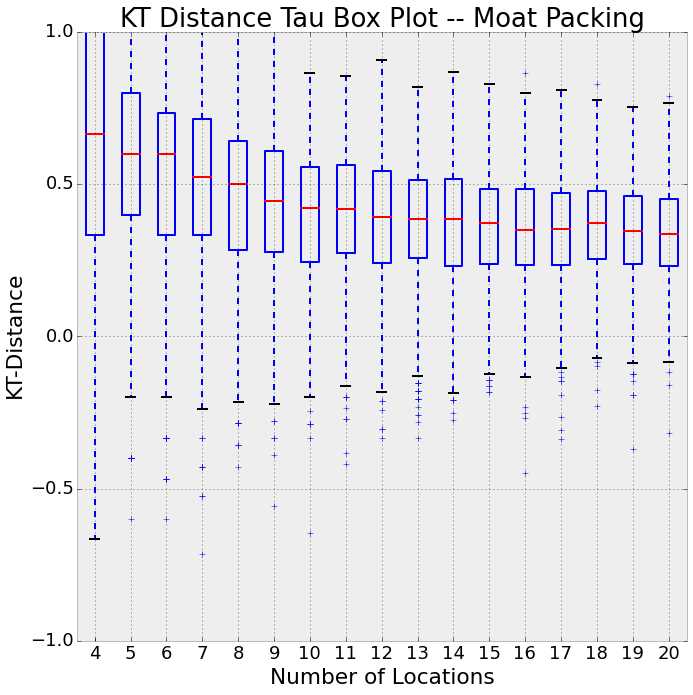

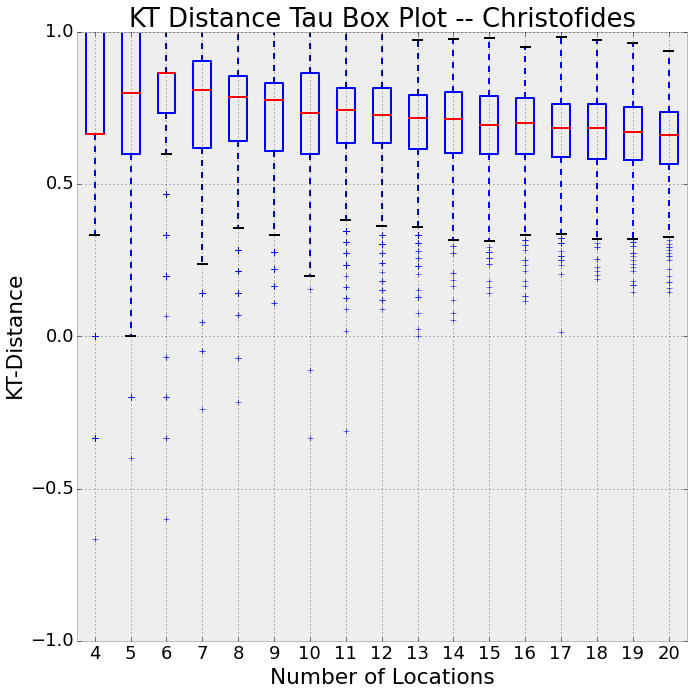

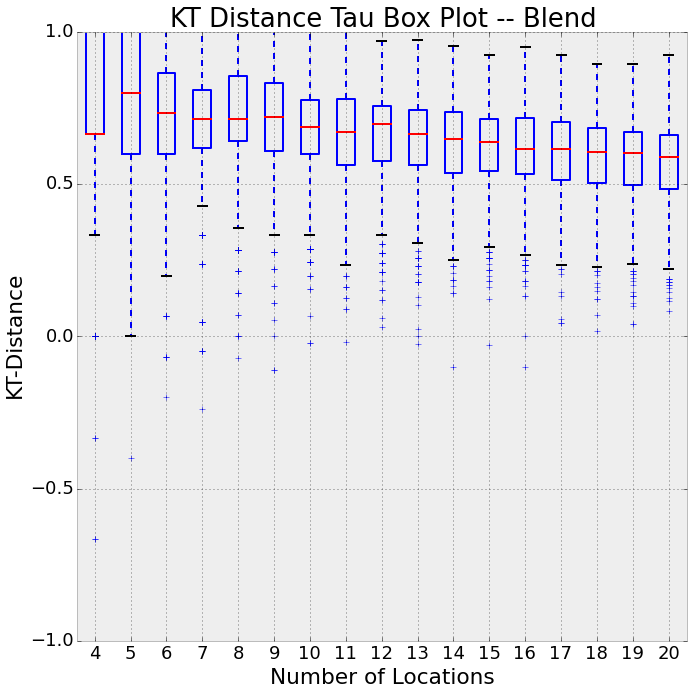

In [10]:
#### KT Box Plots...
def make_kt_boxplots(kt_dist, x_labels):
    Avg = {c:[] for c in Metrics.STAT}
    StDev = {c:[] for c in Metrics.STAT}
    median_p = {c:[] for c in Metrics.STAT}

    for c_metric in Metrics.STAT:
        #Create Figure Object
        fig = plt.figure(figsize=(10, 10))
        # Create an Axes object.
        ax = fig.add_subplot(1,1,1) # one row, two column, first plot

        #make pointers for labels and boxes...
        box_plots = []
        p_values = []
        for c_size in sorted(kt_dist[c_metric].keys()):
            bp = []
            #peal out all the tau's
            for c_t in sorted(kt_dist[c_metric][c_size].keys()):
                bp.append(kt_dist[c_metric][c_size][c_t][0])
                p_values.append(kt_dist[c_metric][c_size][c_t][1])

            Avg[c_metric].append(sum(bp) / float(len(bp)))
            StDev[c_metric].append(np.std(bp))
            box_plots.append(bp)
            median_p[c_metric].append(np.median(p_values))


        ax.boxplot(box_plots)
        xtickNames = plt.setp(ax, xticklabels=x_labels)
        #plt.setp(xtickNames)
        ax.set_title("KT Distance Tau Box Plot -- " + str(c_metric))
        ax.set_ylabel("KT-Distance")
        ax.set_xlabel("Number of Locations")
        ax.set_ylim(-1, 1)
        #draw it to the pdf.
        plt.draw()
        plt.tight_layout()
        #plt.savefig(pp, format='pdf')

    print("Average and SD KT Correlation Values by Metric and Size")
    outline = "{}&".format('Metric')
    for i in [10,15,20, 'all']:
        outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
    print(outline)
    for c_metric in Metrics.STAT:
        outline = "{}&".format(c_metric)
        for i in [10,15,20]:
            outline += "{}&".format(str(round(Avg[c_metric][x_labels.index(i)], 4))) + \
                "{}&".format(str(round(StDev[c_metric][x_labels.index(i)], 4)))
        #All the data...
        outline += "{}&".format(str(round(np.mean(Avg[c_metric]), 4))) + \
                "{}&".format(str(round(np.std(Avg[c_metric]), 4)))
        print(outline)
        
    print("Average and SD KT Correlation Values by Metric and Size")
    outline = "{}&".format('Metric')
    for i in [10,15,20, 'all']:
        outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
    print(outline)
    for c_metric in Metrics.STAT:
        outline = "{}&".format(c_metric)
        for i in [10,15,20]:
            outline += "{}&".format(str(round(Avg[c_metric][x_labels.index(i)], 4))) + \
                "{}&".format(str(round(StDev[c_metric][x_labels.index(i)], 4)))
        #All the data...
        outline += "{}&".format(str(round(np.mean(Avg[c_metric]), 4))) + \
                "{}&".format(str(round(np.std(Avg[c_metric]), 4)))
        print(outline)
        
        
#     ## Dump the stuff to the screen for tables:
#     ## Note: this is messed up, we have a list and the indicies don't correspond to anything....
#     print("Average and SD RMSE by Metric and Size")
#     outline = "{}&".format('Metric')
#     for i in [10,15,20, 'all']:
#         outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
#     print(outline)
#     for c_metric in Metrics.STAT:
#         outline = "{}&".format(c_metric)
#         for i in [10,15,20]:
#             outline += "{}&".format(str(round(Avg[c_metric][x_labels.index(i)], 4))) + \
#                 "{}&".format(str(round(StDev[c_metric][x_labels.index(i)], 4)))
#         #All the data...
#         outline += "{}&".format(str(round(np.mean(Avg[c_metric]), 4))) + \
#                 "{}&".format(str(round(np.std(Avg[c_metric]), 4)))
#         print(outline)

# Setup some box plits...
print("KT Graphs")
make_kt_boxplots(KT_Tests, x_labels)

KT Graphs


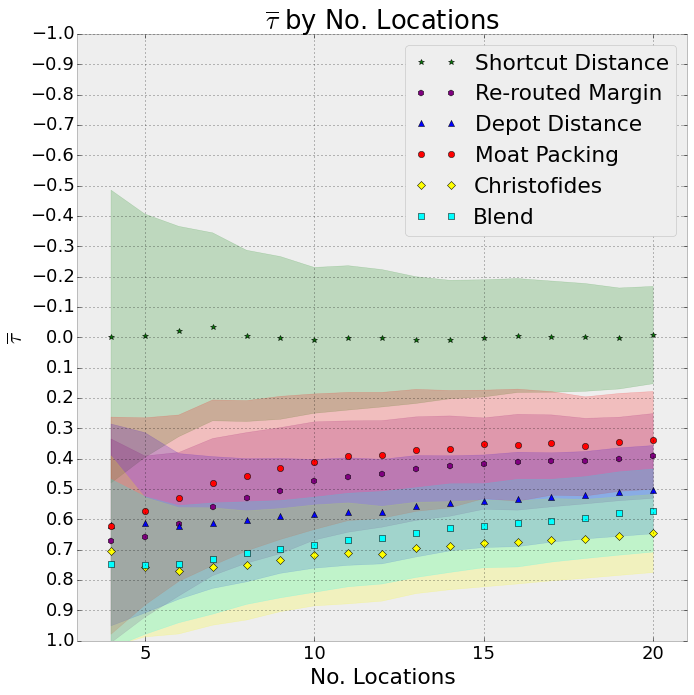

In [15]:
#### KT Snake Plots

def make_kt_snakes(kt_dist, x_labels):
    Avg = {c:[] for c in Metrics.STAT}
    StDev = {c:[] for c in Metrics.STAT}
    median_p = {c:[] for c in Metrics.STAT}

    for c_metric in Metrics.STAT:
        for c_size in sorted(kt_dist[c_metric].keys()):
            bp = []
            #peal out all the tau's
            for c_t in sorted(kt_dist[c_metric][c_size].keys()):
                bp.append(kt_dist[c_metric][c_size][c_t][0])

            Avg[c_metric].append(sum(bp) / float(len(bp)))
            StDev[c_metric].append(np.std(bp))

    #
    ### THIS SECTION MAKES SOME SNAKES!!
    #

    #Attempt to plot the Average Error for them all...
    # Create a Figure object.
    fig2 = plt.figure(figsize=(10, 10))
    # Create an Axes object.
    ax2 = fig2.add_subplot(1,1,1) # one row, one column, first plot
    colors = [ "green", "purple","blue","red", "yellow",  "cyan", "magenta"]
    markers = ["*", "h", "^", "o", "D", "s", "h"]

    c_element = 0
    for c_metric in Metrics.GRAPH:
        thigh = []
        tlow = []
        for i in range(len(Avg[c_metric])):
            thigh.append(Avg[c_metric][i]+StDev[c_metric][i])
            tlow.append(Avg[c_metric][i]-StDev[c_metric][i])

        ax2.plot(x_labels, Avg[c_metric], color=colors[c_element], marker=markers[c_element], label=c_metric, mec="black", linestyle="None")
        ax2.fill_between(x_labels, tlow, thigh, color=colors[c_element], alpha=0.2)
        c_element += 1

    # Add a title.
    ax2.set_title(r"$\overline{\tau}$ by No. Locations")
    # Add some axis labels.
    ax2.set_xlabel("No. Locations")
    ax2.set_ylabel(r"$\overline{\tau}$")
    ax2.set_xlim(x_labels[0]-1, x_labels[len(x_labels)-1]+1)
    ax2.set_ylim(-1, 1)
    plt.yticks(np.arange(-1.0, 1.1, 0.1))
    ax2.legend()
    ax2.invert_yaxis()
    plt.draw()
    plt.tight_layout()
    plt.savefig('synthetic_kt.png',bbox_inches='tight')
  #  plt.savefig(pp, format='pdf')

# Setup some box plits...
print("KT Graphs")
make_kt_snakes(KT_Tests, x_labels)

In [12]:
#### Cell for Real World Data (Sanity Check...)
#### THIS IS AWFUL REUSE!!!

__RW_FNAME_STRING = "/merged*.data"
__RW_INPUT_DIRECTORY = "../../real-world/merged/"

# Glob off all files in the input directory
files = glob.glob(__RW_INPUT_DIRECTORY + __RW_FNAME_STRING)
all_rmse = {c:{} for c in Metrics.STAT}
all_max_pointwise = {c:{} for c in Metrics.STAT}
all_min_pointwise = {c:{} for c in Metrics.STAT}
KT_Tests = {c:{} for c in Metrics.STAT}
error_scatter_x = {c:{} for c in Metrics.STAT}
error_scatter_y = {c:{} for c in Metrics.STAT}

kt_top = {c:{} for c in Metrics.STAT}
kt_bottom = {c:{} for c in Metrics.STAT}
kt_nsig_p = {c:{} for c in Metrics.STAT}
kt_median_p = {c:{} for c in Metrics.STAT}
kt_worst_p = {c:{} for c in Metrics.STAT}
kt_top_3 = {c:{} for c in Metrics.STAT}


x_labels = []

YMAX = 0.0

n_trials = []

print(files)

# Peal off each of the files and try to parse it...
for cfile in sorted(files):
    print("Parsing: " + cfile)
    inf = open(cfile, 'r')
    recs = parseDataFile(inf)
    inf.close()

    #Normalize the records.
    [i.compute_normalized() for i in recs]
    n_trials.append(len(recs))
    print(n_trials)

    # Print the Normalized Rec's...
    #[i.print_normalized() for i in recs]
    #exit()

    #Keep track of our x_labels...
    # Remove the Depot from n locs 
    x_labels.append(recs[0].number_of_locations - 1)
    x_labels = sorted(x_labels)

    #ease of use.
    n_locations = recs[0].number_of_locations

    #Create empty space in the KT_Test Map
    for c_metric in KT_Tests.keys():
        KT_Tests[c_metric][n_locations] = {}

    for c_metric in Metrics.STAT:
        all_rmse[c_metric][n_locations] = []
        all_max_pointwise[c_metric][n_locations] = []
        all_min_pointwise[c_metric][n_locations] = []

        error_scatter_x[c_metric][n_locations] = []
        error_scatter_y[c_metric][n_locations] = []

        kt_top[c_metric][n_locations] = 0
        kt_top_3[c_metric][n_locations] = 0
        kt_bottom[c_metric][n_locations] = 0
        m_p = []

        c_trial = 0
        for c_rec in recs:
            RMSE = 0
            sv = []
            metricrank = []
            t_error = []
            for c_location in sorted(c_rec.normalized.keys()):
                # RSME Calc
                point_error = c_rec.normalized[c_location][c_metric] - c_rec.normalized[c_location][Metrics.SHAPLEY]
                RMSE += point_error * point_error

                #KT stat Calc
                sv.append(c_rec.values[c_location][Metrics.SHAPLEY])
                metricrank.append(c_rec.values[c_location][c_metric])

                #Error Size Calc
                error_scatter_x[c_metric][n_locations].append(round(c_rec.normalized[c_location][Metrics.SHAPLEY] * 100.0, 4))
                #error_scatter_y[c_metric][recs[0].number_of_locations].append(round(abs(c_rec.normalized[c_location][c_metric] - c_rec.normalized[c_location][Metrics.SHAPLEY]) / c_rec.normalized[c_location][Metrics.SHAPLEY], 4))

                t_error.append(abs(c_rec.normalized[c_location][c_metric] - \
                                         c_rec.normalized[c_location][Metrics.SHAPLEY]))

                error_scatter_y[c_metric][n_locations].append( \
                    round(abs(c_rec.normalized[c_location][c_metric] - \
                    c_rec.normalized[c_location][Metrics.SHAPLEY]) * 100, 4))
    
            all_max_pointwise[c_metric][n_locations].append(max(t_error))
            all_min_pointwise[c_metric][n_locations].append(min(t_error))
            all_rmse[c_metric][n_locations].append(math.sqrt(RMSE))
            if math.sqrt(RMSE) > YMAX:
                YMAX = math.sqrt(RMSE)

            #KT test stat testing...
            KT_Tests[c_metric][n_locations][c_trial] = stats.mstats.kendalltau(sv, metricrank,use_ties=True)
            #KT_Tests[c_metric][recs[0].number_of_locations][c_trial] = stats.kendalltau(sv, metricrank)
            #KT_Tests[c_metric][recs[0].number_of_locations][c_trial] = -1, -1

            m_p.append(KT_Tests[c_metric][n_locations][c_trial][1])
            c_trial += 1
            if sv.index(max(sv)) == metricrank.index(max(metricrank)):
                kt_top[c_metric][n_locations] += 1
            if sv.index(min(sv)) == metricrank.index(min(metricrank)):
                kt_bottom[c_metric][n_locations] += 1
                
            ### Here, need to take the top 3 and check..
            top_sv = list(enumerate(sv))
            top_sv = sorted(top_sv, key=lambda x:x[1], reverse=True)
            topn_sv = set([l for l,v in top_sv[:3]])

            top_kt = list(enumerate(metricrank))
            top_kt = sorted(top_kt, key=lambda x:x[1], reverse=True)
            topi_kt = [l for l,v in top_kt[:1]]
            
            if topi_kt[0] in topn_sv:
                kt_top_3[c_metric][n_locations] += 1

        kt_nsig_p[c_metric][n_locations] = sum(x < 0.05 for x in m_p)
        kt_median_p[c_metric][n_locations] = np.median(m_p)
        kt_worst_p[c_metric][n_locations] = max(m_p)
        
        

print("Done")


['../../real-world/merged/merged_10.data', '../../real-world/merged/merged_20.data']
Parsing: ../../real-world/merged/merged_10.data
[71]
Parsing: ../../real-world/merged/merged_20.data
[71, 48]
Done


{10: 16, 20: 43}
[71, 48]
[71, 48, 119]

% KT p Values p < 0.05 by Metric and Size
Metric&    10    &    20    &   all    &
Shortcut Distance&  4.2254  &  8.3333  &  5.8824  &
Re-routed Margin&  28.169  & 72.9167  & 46.2185  &
Depot Distance& 12.6761  &  43.75   & 25.2101  &
Moat Packing& 25.3521  &   62.5   & 40.3361  &
Christofides& 22.5352  & 89.5833  & 49.5798  &
  Blend   & 14.0845  &  68.75   & 36.1345  &

Number out of [71, 48] with matching top ranked (costliest) elemnent.
  Metric  ,    10    &    20    &   all    &
Shortcut Distance, 12.6761  &  18.75   & 15.1261  &
Re-routed Margin, 57.7465  & 70.8333  & 63.0252  &
Depot Distance, 53.5211  & 60.4167  & 56.3025  &
Moat Packing, 60.5634  &  56.25   & 58.8235  &
Christofides, 57.7465  &   62.5   & 59.6639  &
Blend,  56.338  & 64.5833  & 59.6639  &

Number out of [71, 48] with matching inclusin in top 3 elements.
  Metric  ,    10    &    20    &   all    &
Shortcut Distance, 36.6197  & 22.9167  & 31.0924  &
Re-routed Margin, 74

NameError: name 'make_pointwise_error_snakes' is not defined

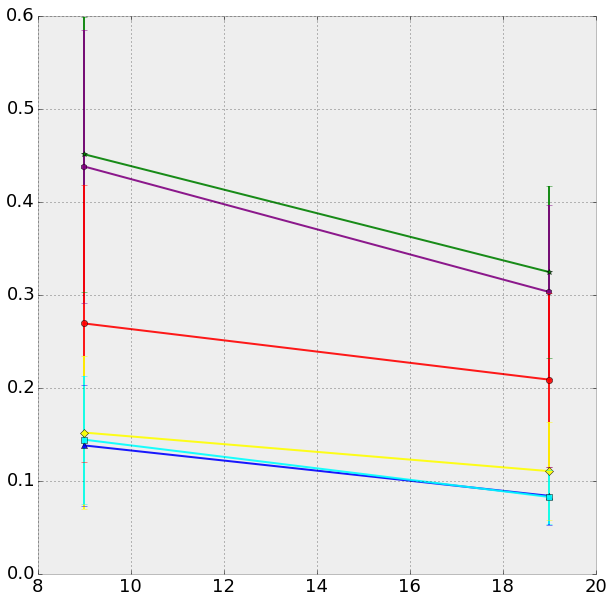

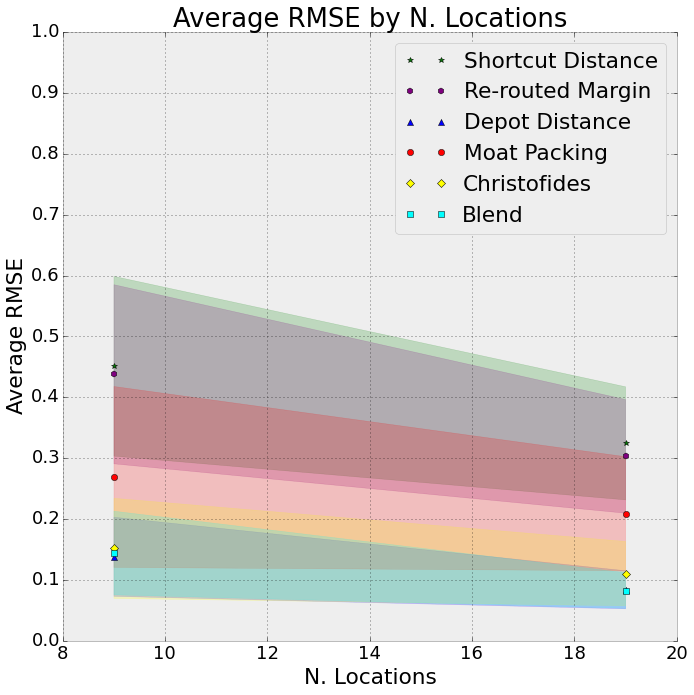

In [13]:
#### Paper Tables and Definitions -- only works for REAL WORLD DATA!!!

print(kt_nsig_p[Metrics.CHRIS])
print(n_trials)
ct = n_trials + [sum(n_trials)]
print(ct)

print("\n% KT p Values p < 0.05 by Metric and Size")
outline = "{}&".format('Metric')
for i, j in zip([10,20,'all'], ct):
    outline += "{:^10}&".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{:^10}&".format(c_metric)
    for i, j in zip([10,20], ct):
        outline += "{:^10}&".format(str(round((kt_nsig_p[c_metric][i] / float(j)) * 100.0 , 4)))
        #outline += "{:^10}&".format(str(round(float(kt_nsig_p[c_metric][i]), 4)))
# #All the data...
    outline += "{:^10}&".format(str(round((sum(kt_nsig_p[c_metric].values()) / float(sum(n_trials)))*100.0, 4)))
    print(outline)

print("\nNumber out of " + str(n_trials) + " with matching top ranked (costliest) elemnent.")
outline = "{:^10},".format('Metric')
for i, j in zip([10,20,'all'], ct):
    outline += "{:^10}&".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{},".format(c_metric)
    for i, j in zip([10,20], ct):
        outline += "{:^10}&".format(str(round((kt_top[c_metric][i] / float(j)) * 100.0 , 4)))
    outline += "{:^10}&".format(str(round((sum(kt_top[c_metric].values()) / float(sum(n_trials)))*100.0, 4)))
    print(outline)

print("\nNumber out of " + str(n_trials) + " with matching inclusin in top 3 elements.")
outline = "{:^10},".format('Metric')
for i, j in zip([10,20,'all'], ct):
    outline += "{:^10}&".format(str(i))
print(outline)
for c_metric in Metrics.STAT:
    outline = "{},".format(c_metric)
    for i, j in zip([10,20], ct):
        outline += "{:^10}&".format(str(round((kt_top_3[c_metric][i] / float(j)) * 100.0 , 4)))
    outline += "{:^10}&".format(str(round((sum(kt_top_3[c_metric].values()) / float(sum(n_trials)))*100.0, 4)))
    print(outline)   
    
print("mean max and SD absolute pointwise error.")
outline = "{}&".format('Metric')
for i in [10,20]:
    outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
print(outline)
for c_metric in Metrics.STAT:
    outline = "{:^10}&".format(c_metric)
    for i in [10,20]:
        outline += "{:^10}&".format(str(round(np.mean(all_max_pointwise[c_metric][i]), 4))) + \
                   "{:^10}&".format(str(round(np.std(all_max_pointwise[c_metric][i]), 4)))
#        outline += "{:^10}&".format(str(round(all_min_pointwise[c_metric][i], 4)))
    # All Data
    outline += "{}&".format(str(round(np.mean(np.hstack( all_max_pointwise[c_metric].values() )), 4))) + \
               "{}&".format(str(round(np.std(np.hstack(all_max_pointwise[c_metric].values())), 4)))
    print(outline)

    
    
    # RMSE ERROR SNAKES...
def make_error_snakes(Big_Plot, x_labels, y_max):
    Mins = {c:[] for c in Metrics.STAT}
    Maxes = {c:[] for c in Metrics.STAT}
    Avg = {c:[] for c in Metrics.STAT}
    StDev = {c:[] for c in Metrics.STAT}
    Median = {c:[] for c in Metrics.STAT}
    ErMax = 0.7

    for c_metric in Metrics.STAT:
        for c_loc in sorted(Big_Plot[c_metric]):
            Mins[c_metric].append(min(Big_Plot[c_metric][c_loc]))
            Maxes[c_metric].append(max(Big_Plot[c_metric][c_loc]))
            Avg[c_metric].append(sum(Big_Plot[c_metric][c_loc]) / len(Big_Plot[c_metric][c_loc]))
            StDev[c_metric].append(np.std(Big_Plot[c_metric][c_loc]))
            Median[c_metric].append(np.median(Big_Plot[c_metric][c_loc]))
            
    print("Creating RMSE Graphs")

    #
    ### THIS SECTION MAKES THE LINE GRAPH WITH ERROR BARS!!
    #

    # Create a Figure object.
    fig = plt.figure(figsize=(10, 10))
    # Create an Axes object.
    ax = fig.add_subplot(1,1,1) # one row, one column, first plot
    colors = [ "green", "purple","blue","red", "yellow",  "cyan", "magenta"]
    markers = ["*", "h", "^", "o", "D", "s", "h"]

    for c_element, c_metric in enumerate(Metrics.GRAPH):
        ax.errorbar(x_labels, Avg[c_metric], yerr=StDev[c_metric], \
            color=colors[c_element], marker=markers[c_element], label=c_metric, alpha=0.9)

    #Attempt to plot the Average Error for them all...
    # Create a Figure object.
    fig = plt.figure(figsize=(10, 10))
    # Create an Axes object.
    ax = fig.add_subplot(1,1,1) # one row, one column, first plot

    for c_element, c_metric in enumerate(Metrics.GRAPH):
        thigh = []
        tlow = []
        for i in range(len(Avg[c_metric])):
            thigh.append(Avg[c_metric][i]+StDev[c_metric][i])
            tlow.append(Avg[c_metric][i]-StDev[c_metric][i])

        ax.plot(x_labels, Avg[c_metric], color=colors[c_element], \
            marker=markers[c_element], label=c_metric, mec="black", linestyle="None")
        ax.fill_between(x_labels, tlow, thigh, color=colors[c_element], alpha=0.2)

    # Add a title.
    ax.set_title("Average RMSE by N. Locations")
    # Add some axis labels.
    ax.set_xlabel("N. Locations")
    ax.set_ylabel("Average RMSE")
    ax.set_xlim(x_labels[0]-1, x_labels[len(x_labels)-1]+1)
    ax.set_ylim(0, y_max)
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    ax.legend()
    plt.draw()
    plt.tight_layout()
    plt.savefig('synthetic_rmse.png',bbox_inches='tight')
    
    print(Avg[Metrics.CHRIS])

    ## Dump the stuff to the screen for tables:
    ## Note: this is messed up, we have a list and the indicies don't correspond to anything....
    print("Average and SD RMSE by Metric and Size")
    outline = "{}&".format('Metric')
    for i in [10,20, 'all']:
        outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
    print(outline)
    for c_metric in Metrics.STAT:
        outline = "{}&".format(c_metric)
        for i in [0,1]:
            outline += "{}&".format(str(round(Avg[c_metric][i], 4))) + \
                "{}&".format(str(round(StDev[c_metric][i], 4)))
        #All the data...
        outline += "{}&".format(str(round(np.mean(Avg[c_metric]), 4))) + \
                "{}&".format(str(round(np.std(Avg[c_metric]), 4)))
        print(outline)

        
def make_kt_boxplots(kt_dist, x_labels):
    Avg = {c:[] for c in Metrics.STAT}
    StDev = {c:[] for c in Metrics.STAT}
    median_p = {c:[] for c in Metrics.STAT}

    for c_metric in Metrics.STAT:
        #Create Figure Object
        fig = plt.figure(figsize=(10, 10))
        # Create an Axes object.
        ax = fig.add_subplot(1,1,1) # one row, two column, first plot

        #make pointers for labels and boxes...
        box_plots = []
        p_values = []
        for c_size in sorted(kt_dist[c_metric].keys()):
            bp = []
            #peal out all the tau's
            for c_t in sorted(kt_dist[c_metric][c_size].keys()):
                bp.append(kt_dist[c_metric][c_size][c_t][0])
                p_values.append(kt_dist[c_metric][c_size][c_t][1])

            Avg[c_metric].append(sum(bp) / float(len(bp)))
            StDev[c_metric].append(np.std(bp))
            box_plots.append(bp)
            median_p[c_metric].append(np.median(p_values))


        ax.boxplot(box_plots)
        xtickNames = plt.setp(ax, xticklabels=x_labels)
        #plt.setp(xtickNames)
        ax.set_title("KT Distance Tau Box Plot -- " + str(c_metric))
        ax.set_ylabel("KT-Distance")
        ax.set_xlabel("Number of Locations")
        ax.set_ylim(-1, 1)
        #draw it to the pdf.
        plt.draw()
        plt.tight_layout()
        #plt.savefig(pp, format='pdf')

    print("Average and SD KT Correlation Values by Metric and Size")
    outline = "{}&".format('Metric')
    for i in [10,20, 'all']:
        outline += "{:^10}&".format(str(i)) + "{:^10}&".format("SD")
    print(outline)
    for c_metric in Metrics.STAT:
        outline = "{}&".format(c_metric)
        for i in [0,1]:
            outline += "{}&".format(str(round(Avg[c_metric][i], 4))) + \
                "{}&".format(str(round(StDev[c_metric][i], 4)))
        #All the data...
        outline += "{}&".format(str(round(np.mean(Avg[c_metric]), 4))) + \
                "{}&".format(str(round(np.std(Avg[c_metric]), 4)))
        print(outline)
        


#print("Generating RMSE Error Boxes")
#make_error_boxplot(all_rmse, x_labels, YMAX)

print("Generating RMSE Snakes")
make_error_snakes(all_rmse, x_labels, 1.0)

print("Generating Pointwise Max/Min Plots")
make_pointwise_error_snakes(all_max_pointwise, x_labels, 0.52)

# Setup some box plits...
print("KT Graphs")
make_kt_boxplots(KT_Tests, x_labels)

In [15]:
#### Leftover Code For making Scatter Error Plots (NOT TESTED!!)
# For each of the Metrics, across all sizes, we want to 
# make a scatter plot that is (SV Allocation %, Average RMSE).
# This may give us a visual on where the errors are occuring.
#
#
# def make_alloc_error_plot(pp, x_val, y_val):
#     for c_metric in Metrics.STAT:

#         #One for each size and one for the union of all the sizes...
#         x_union = []
#         y_union = []

#         for c_size in sorted(x_val[c_metric].keys()):
#             x_clip = copy.copy(x_val[c_metric][c_size])
#             y_clip = copy.copy(y_val[c_metric][c_size])

#             #Clip off negitive values as they are the result of some numerical instablility
#             for c in range(len(x_clip)):
#                 if x_clip[c] <= 0.000000000:
#                     x_clip[c] = 0.00000001
#                 if y_clip[c] <= 0.000000000:
#                     y_clip[c] = 0.00000001
#             # Scale up y union to %'s
#             #y_clip = [x*100 for x in y_clip]

#             x_union += x_clip
#             y_union += y_clip

#             #Create Figure
#             fig = plt.figure(figsize=(10,10))
#             #create an axis
#             plt.minorticks_on()
#             sc_ax = fig.add_subplot(1,1,1)
#             sc_ax.scatter(x_clip, y_clip)
#             sc_ax.set_title(str(c_size) + " Locations, Proxy: " + c_metric)
#             sc_ax.set_ylabel("Absolute Difference between Fractional Shapley and Proxy")
#             sc_ax.set_xlabel("Fraction of Total Shapley Allocation")
#             sc_ax.set_xlim(0, 100)
#             sc_ax.set_ylim(0, 20*100)
#             #Logging...
#             plt.xscale('symlog')
#             sc_ax.xaxis.grid(True, which='major') 
#             plt.yscale('symlog')
#             sc_ax.yaxis.grid(True, which='major') 

#             plt.draw()
#             plt.tight_layout()
#             plt.savefig(pp, format='pdf')

#         #Create Figure
#         fig = plt.figure(figsize=(10,10))
#         plt.minorticks_on()
#         #create an axis
#         sc_ax = fig.add_subplot(1,1,1)
#         #One more for the union...

#         sc_ax.scatter(x_union, y_union)
#         sc_ax.set_title("All Locations, Proxy: " + c_metric)
#         sc_ax.set_ylabel("Absolute Difference between Fractional Shapley and Proxy")
#         sc_ax.set_xlabel("Fraction of Total Shapley Allocation")
#         sc_ax.set_xlim(0, 100)
#         sc_ax.set_ylim(0, 20*100)
#         #Logging...
#         plt.xscale('symlog')
#         sc_ax.xaxis.grid(True, which='major') 
#         plt.yscale('symlog')
#         sc_ax.yaxis.grid(True, which='major') 

#         plt.draw()
#         plt.tight_layout()
#         plt.savefig(pp, format='pdf')

# pd = PdfPages(sys.argv[2] + "Scatter_Error.pdf")
# #Display the Average Normed RMSE as a function of allocation % in SV per metric.
# make_alloc_error_plot(pd, error_scatter_x, error_scatter_y)
# pd.close()